In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


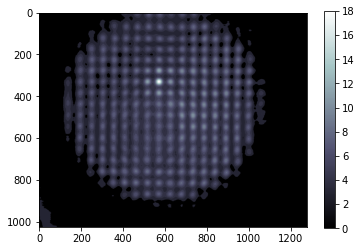

In [741]:
im_smooth=np.load("../ims.npy")
plt.imshow( im_smooth, cmap='bone' )
plt.colorbar()

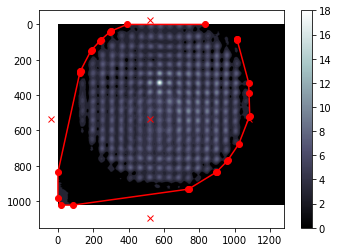

In [742]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy.optimize import minimize
from skimage import filters

from fit_circle import circle_fitter
import mmap

if True:
            points = np.array( np.where( im_smooth ) ).T     # Coords of non-zero points
            hull = ConvexHull(points)
            fit1 = circle_fitter(hull.points[hull.vertices,1], hull.points[hull.vertices,0] ) # Note dimensions switched!
            fit1.solve()
            opt1 = fit1.params
            
            r_pix = opt1[2]
            # Find closest box center
            #distances =(self.parent.box_x - self.opt1[0])**2 + (self.parent.box_y - self.opt1[1])**2


if True:
    plt.imshow( im_smooth, cmap='bone' )
    plt.colorbar()

    plt.plot( opt1[0], opt1[1], 'rx' )
    plt.plot( opt1[0]+r_pix, opt1[1], 'rx' )
    plt.plot( opt1[0]-r_pix, opt1[1], 'rx' )
    plt.plot( opt1[0], opt1[1]+r_pix, 'rx' )
    plt.plot( opt1[0], opt1[1]-r_pix, 'rx' )

    plt.plot( hull.points[hull.vertices,1], hull.points[hull.vertices,0], 'ro-' )

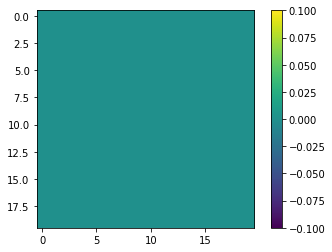

In [649]:
plt.imshow( im_smooth[950:970,0:20] )
plt.colorbar()

In [650]:
hull

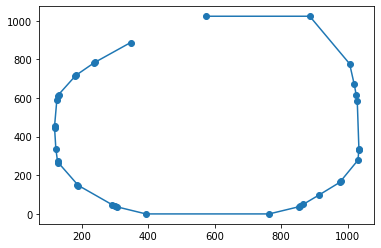

In [651]:
plt.plot( hull.points[hull.vertices,1], hull.points[hull.vertices,0], 'o-' )

In [652]:
list( zip( hull.points[hull.vertices,1],hull.points[hull.vertices,0] ) )

[(573.0, 1023.0),
 (886.0, 1023.0),
 (1006.0, 777.0),
 (1020.0, 670.0),
 (1026.0, 615.0),
 (1029.0, 586.0),
 (1034.0, 336.0),
 (1034.0, 330.0),
 (1031.0, 278.0),
 (980.0, 171.0),
 (976.0, 163.0),
 (915.0, 99.0),
 (866.0, 49.0),
 (856.0, 39.0),
 (853.0, 37.0),
 (764.0, 0.0),
 (393.0, 0.0),
 (305.0, 37.0),
 (301.0, 39.0),
 (291.0, 48.0),
 (190.0, 147.0),
 (187.0, 152.0),
 (129.0, 266.0),
 (127.0, 272.0),
 (122.0, 336.0),
 (118.0, 447.0),
 (118.0, 453.0),
 (125.0, 591.0),
 (127.0, 609.0),
 (130.0, 617.0),
 (181.0, 715.0),
 (183.0, 718.0),
 (237.0, 782.0),
 (240.0, 785.0),
 (347.0, 887.0)]

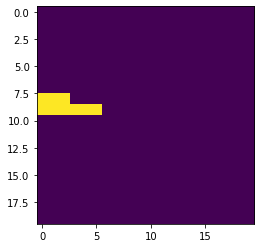

In [167]:
%load_ext autoreload
%autoreload 2
from fit_circle import circle_fitter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [699]:
hull_sample

array([30, 15, 18, 10, 28, 19, 22, 14, 25, 26, 24])

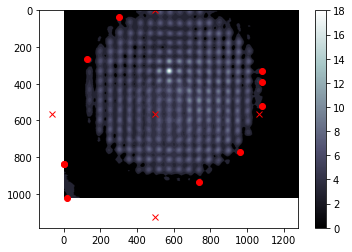

In [743]:
nboots=100
fraction=3
sample_size=hull.vertices.shape[0]//fraction
bootres = np.zeros( (nboots,4))
samples = np.zeros( (nboots,sample_size))
for nboot in np.arange(nboots):
    points = np.array( np.where( im_smooth ) ).T     # Coords of non-zero points
    hull = ConvexHull(points)
    
    hull_sample = np.random.randint(0,hull.vertices.shape,size=sample_size )
    samples[nboot] = hull_sample
    hull_idxs = hull.vertices[hull_sample]
    fit1 = circle_fitter(hull.points[hull_idxs,1], hull.points[hull_idxs,0] ) # Note dimensions switched!
    fit1.solve()
    opt1 = fit1.params

    r_pix = opt1[2]
    logloss=np.log10(fit1.circle_err(opt1 ) )
    bootres[nboot]=np.concatenate( (opt1, [logloss]))
    #print( '.',end='')
    #print( opt1, np.log10(fit1.circle_err(opt1 ) ) )
            # Find closest box center
            #distances =(self.parent.box_x - self.opt1[0])**2 + (self.parent.box_y - self.opt1[1])**2

plt.imshow( im_smooth, cmap='bone' )
plt.colorbar()

plt.plot( opt1[0], opt1[1], 'rx' )
plt.plot( opt1[0]+r_pix, opt1[1], 'rx' )
plt.plot( opt1[0]-r_pix, opt1[1], 'rx' )
plt.plot( opt1[0], opt1[1]+r_pix, 'rx' )
plt.plot( opt1[0], opt1[1]-r_pix, 'rx' )

plt.plot( hull.points[hull_idxs,1], hull.points[hull_idxs,0], 'ro' )

In [708]:
bootres[idxs[0:4]]

array([[576.033558  , 435.72766513, 481.76092096,   7.68627893],
       [572.04080836, 436.04372423, 479.24995139,   8.1267737 ],
       [589.48177728, 423.16915451, 476.10864844,   8.3659534 ],
       [581.26837953, 431.55200306, 477.98091538,   8.52377548]])

In [745]:
idxs=np.argsort(bootres[:,3])

# Sort by log total_error of the sample fit.
# Make sure we don't get a weird sample that fits too well--
# We want 5 boots to agree.
nagree=5
candidates=np.arange(0,len(bootres))
stds = np.zeros( (len(candidates),4))
for nstart in candidates:
    # Examine std of fitted centers and radii
    std_boot1 = np.std( bootres[idxs[nstart:nstart+nagree]], 0)
    stds[nstart] = std_boot1    
    #print( bootres[idxs[nstart]], std_boot1)
    # radius of 5 pixels of x and y and radii std of<10
    if (std_boot1[0]**2+std_boot1[1]**2 < 50) and (std_boot1[2]<10):
        break

best_guess = np.mean( bootres[idxs[nstart:nstart+nagree]],0)
print ( nstart )
print( best_guess)

0
[590.52760819 447.65808534 499.91160824   8.36351057]


<Axes: ylabel='Density'>

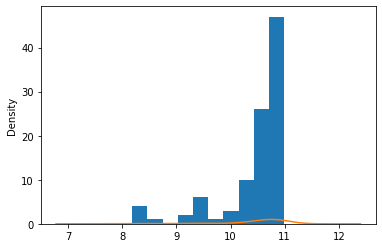

In [746]:
df_fits.iloc[:,3].plot(kind='hist')
df_fits.iloc[:,3].plot(kind='kde')

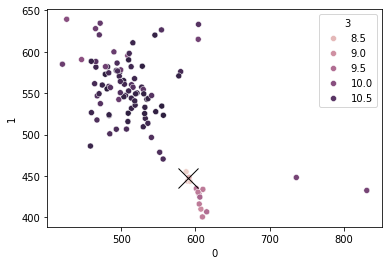

In [747]:
import pandas as pd
import seaborn as sns
df_fits = pd.DataFrame(bootres)

sns.scatterplot(data=df_fits,x=0,y=1,hue=3)
plt.plot( best_guess[0], best_guess[1], 'kx',ms=20)

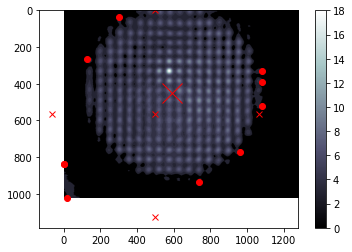

In [749]:
plt.imshow( im_smooth, cmap='bone' )
plt.colorbar()

plt.plot( opt1[0], opt1[1], 'rx' )
plt.plot( opt1[0]+r_pix, opt1[1], 'rx' )
plt.plot( opt1[0]-r_pix, opt1[1], 'rx' )
plt.plot( opt1[0], opt1[1]+r_pix, 'rx' )
plt.plot( opt1[0], opt1[1]-r_pix, 'rx' )

plt.plot( hull.points[hull_idxs,1], hull.points[hull_idxs,0], 'ro' )

plt.plot( best_guess[0], best_guess[1], 'rx',ms=20)

In [224]:
fit1 = circle_fitter(hull.points[hull.vertices,1], hull.points[hull.vertices,0] ) # Note dimensions switched!
fit1.params = bootres[-1,0:3]

In [225]:
fit1.circle_err(bootres[-1,0:3])

265712806388.1494

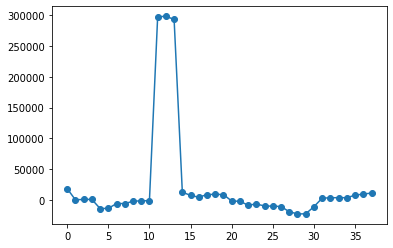

In [226]:
plt.plot( ( fit1.losses ), 'o-')

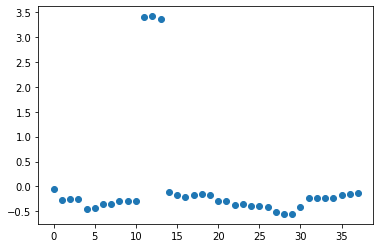

In [227]:
plt.plot( (fit1.losses - np.mean( fit1.losses ) ) / fit1.losses.std(), 'o')

In [228]:
from PIL import Image


In [479]:
im_rot=Image.open("/home/dcoates/data/jj/018/DD/H/sweep_cam1_SWSC124_cam1_H_002.bmp")
im_rot=Image.open("/home/dcoates/data/jj/015/DD/H/sweep_cam1_SWSC124_cam1_H_002.bmp")
#im_rot=Image.open("/home/dcoates/data/jj/005 (discontinued)/DD/H/sweep_cam1_H_023.bmp")

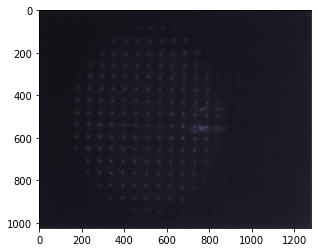

In [480]:
arot = np.array(im_rot)
plt.imshow( np.array(im_rot), cmap='bone' )
im_smooth = gaussian_filter(arot,3)

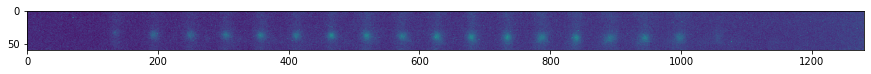

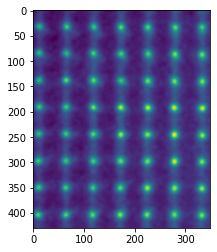

In [473]:
import numpy.random as random
from scipy.ndimage import gaussian_filter



plt.figure(figsize=(15,4))
plt.imshow( arot[400:460,:] )
plt.figure(figsize=(15,4))
plt.imshow( im_smooth[300:730,400:750] )

In [515]:
import cv2 as cv
 
img = (im_smooth)
assert img is not None, "file could not be read, check with os.path.exists()"
 
M = np.float32([[1,0,0],[0,1,0]])

angls=np.linspace(-4,4,200)

maxes=np.zeros( (2,len(angls)))
mins=np.zeros( (2,len(angls)))

best_metric=-1

for nangle,angl1 in enumerate(angls):
    height,width=img.shape
    M = cv.getRotationMatrix2D((width/2,height/2),angl1,1)
    res = cv.warpAffine(img,M, (width,height) )
    res[res<img.min()] = img.min()
    #res = res[0:img.shape[1], 0:img.shape[0]]
    #print( img.shape, res.shape )

    #im_patch=im_smooth[300:730,400:750]
    #rot_patch=res[300:730,400:750]
    patch_size=400
    im_patch=im_smooth[height//2-patch_size:height//2+patch_size,width//2-patch_size:width//2+patch_size]
    rot_patch=res[height//2-patch_size:height//2+patch_size,width//2-patch_size:width//2+patch_size]
        
    if False:
        plt.figure( figsize=(12,12) )
        plt.subplot(2,2,1)
        plt.imshow(img/np.max(img)*255,cmap='bone')
        plt.subplot(2,2,2)
        plt.imshow( res/np.max(res)*255,cmap='bone' )

        plt.subplot(2,2,3)
        plt.plot( np.mean(im_patch,0), label='img' )
        plt.plot( np.mean(rot_patch,0), label='rot')
        plt.legend()

        plt.subplot(2,2,4)
        dim1=1
        plt.plot( np.mean(im_patch,dim1), label='img' )
        plt.plot( np.mean(rot_patch,dim1), label='rot')
        plt.legend()

    for dim1 in [0,1]:
        max1=np.max( np.mean(im_patch,dim1) )
        maxes[dim1,nangle]=max1
        min1=np.min( np.mean(rot_patch,dim1) )
        mins[dim1,nangle]=min1        
        
    if (maxes[0,nangle]-mins[0,nangle]) + (maxes[1,nangle]-mins[1,nangle]) > best_metric:
        best_metric = (maxes[0,nangle]-mins[0,nangle]) + (maxes[1,nangle]-mins[1,nangle])
        best_idx = nangle
        patch_best = rot_patch

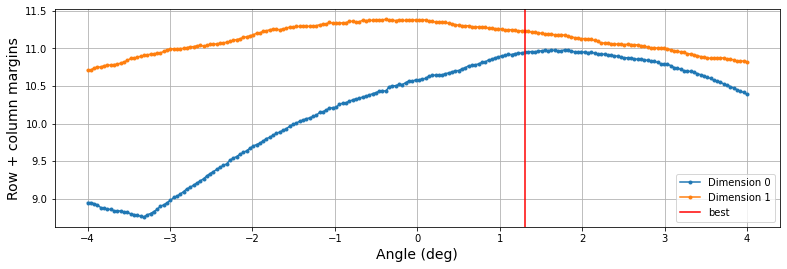

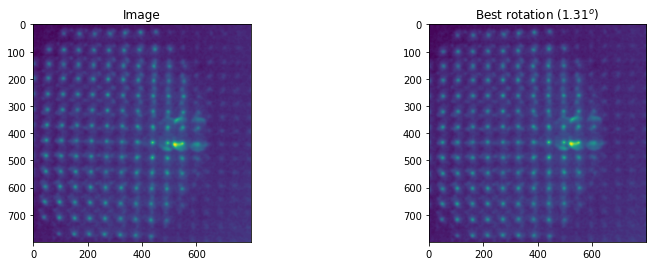

In [516]:
plt.figure(figsize=(13,4))
plt.plot( angls,maxes[0]-mins[0], '.-', label='Dimension 0' )
plt.plot( angls,maxes[1]-mins[1], '.-', label='Dimension 1' )
plt.axvline(angls[best_idx], label='best', color='r')
plt.grid()
plt.xlabel("Angle (deg)",size=14)
plt.ylabel("Row + column margins",size=14)
plt.legend()

plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
plt.imshow(im_patch)
plt.title('Image')
plt.subplot(1,2,2)
plt.title('Best rotation (%0.2f$^o$)'%(angls[best_idx]))
plt.imshow(patch_best)

In [446]:
best_metric,best_idx,angls[best_idx]

(22.572499999999998, 86, -0.5427135678391961)

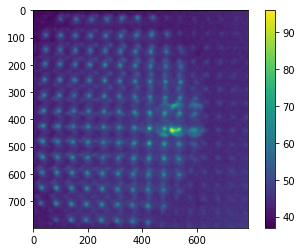

In [528]:
plt.imshow(im_patch[2:,12:]) #[50:100,50:100])
plt.colorbar()

In [532]:
np.array(np.arange(0,100,33.3), dtype='int')

array([ 0, 33, 66, 99])

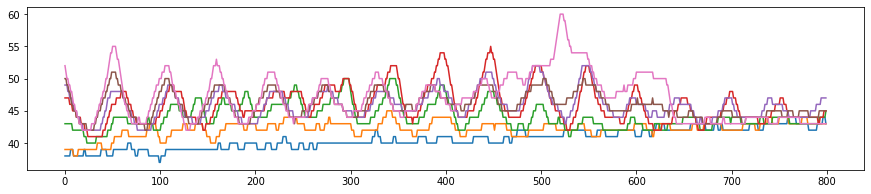

In [536]:
plt.figure(figsize=(15,3))
phase=0
tot=im_patch[np.arange(9,400,59),:]
plt.plot( tot.T )

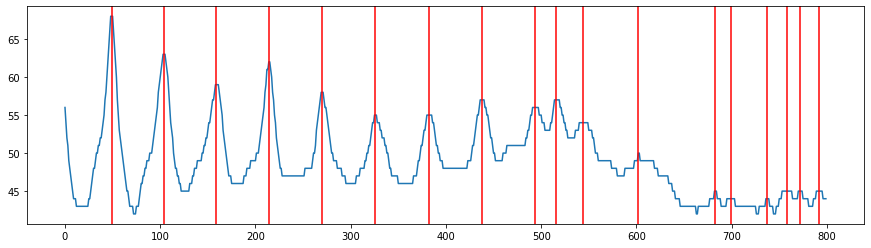

In [571]:
plt.figure(figsize=(15,4))
pks=find_peaks(im_patch[425,:])[0]
plt.plot( im_patch[425,:] )
for pk1 in pks:
    plt.axvline( pk1,color='r')

In [572]:
np.diff( pks)

array([55, 55, 55, 56, 56, 56, 56, 56, 22, 28, 58, 81, 16, 38, 21, 14, 20])

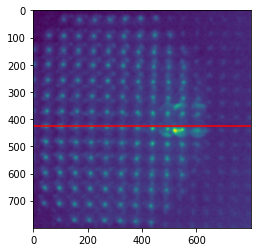

In [578]:
plt.imshow( im_patch )
plt.axhline(425, color='r')

In [590]:
ft.shape,width,height,width/56,height/56

((1024,), 1280, 1024, 22.857142857142858, 18.285714285714285)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


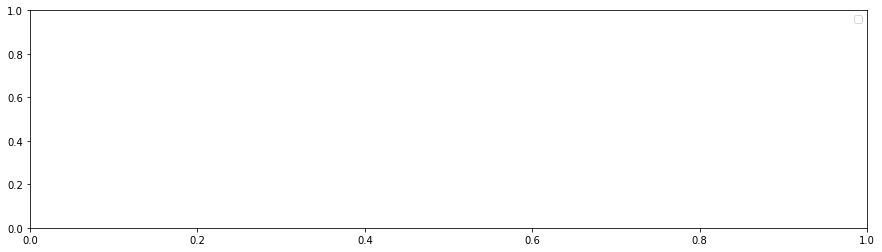

In [606]:
plt.figure(figsize=(15,4))

angls=np.linspace(-3,3,100)
goods=np.zeros( (len(angls)))
for nangle,angl1 in enumerate(angls):
    height,width=img.shape
    M = cv.getRotationMatrix2D((width/2,height/2),angl1,1)
    res = cv.warpAffine(img,M, (width,height) )
    
    sig=np.sum(res,0)
    ft=fft.fft(sig);
    #lins=plt.plot(np.arange(10,30), np.abs(ft[10:30]), '.-', label=angl1)
    
    
    sig=np.sum(res,1)
    ft=fft.fft(sig);
    #plt.plot(np.arange(10,30), np.abs(ft[10:30]), 'x-', color=lins[0].get_color())
    goods[nangle] = np.abs(ft[18])
    
plt.legend()

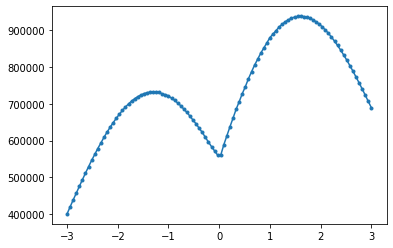

In [607]:
plt.plot ( angls,goods, '.-')

[55 56 55 57 55 55]


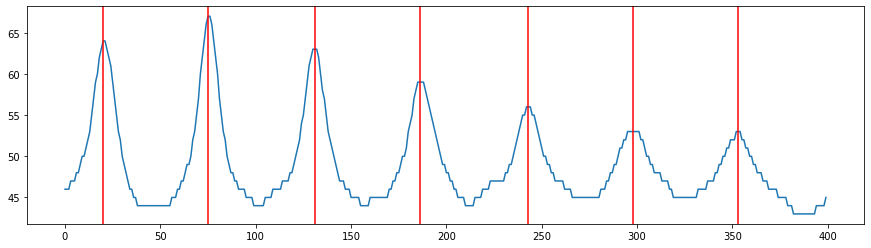

In [509]:
from scipy.signal import find_peaks

plt.figure(figsize=(15,4))
plt.plot(im_patch[0])
pks=find_peaks(im_patch[0])[0]
print( np.diff( pks) )

for pk1 in pks:
    plt.axvline(pk1, color='r')

array([ 20,  75, 131, 186, 243, 298, 353])

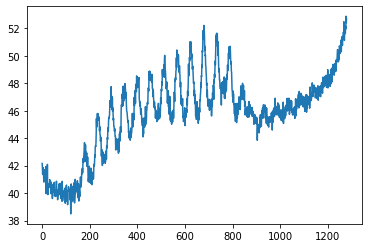

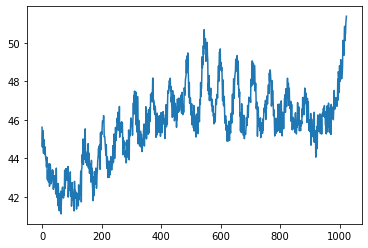

In [241]:
plt.plot( np.mean( arot, 0) )
plt.figure()
plt.plot( np.mean( arot, 1) )